# Fine tune ResNet-50

In [14]:
from torchvision import models
import pandas as pd
import shutil
import random
from DicomRTTool.ReaderWriter import DicomReaderWriter, ROIAssociationClass
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset
import pickle
import json
import torch.nn.functional as F
import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
from sklearn.preprocessing import label_binarize
import wandb
from sklearn.metrics import roc_curve, auc

## Load train dataset

In [4]:
class CTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

In [5]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

train_array_list = np.load(os.path.join(np_folder_path, "small_train_arrays.npy"), allow_pickle=True)


with open(os.path.join(np_folder_path, "small_train_labels_np.json"), "r") as file:
    train_labels_list = json.load(file)

In [6]:
dataset = CTDataset(train_array_list, train_labels_list)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

## Load dev dataset

In [21]:
path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/train_dev_test_lists'
with open(os.path.join(path, "small_dev_data.json"), "r") as file:
    dev_data = json.load(file)

with open(os.path.join(path, "small_dev_labels.json"), "r") as file:
    dev_labels = json.load(file)

In [22]:
skip = 4
total_dev_arrays = []
total_dev_labels = []
missed_list = []
lung_list = ['both lungs', 'lung_whole', 'total lung', 'combo lung', 'combined lung', 'whole lung', 'lungs', 'whole_lung', 'composite lung', 'combo lungs']


for i in range(len(dev_data)):
    try:
        single_arrays = []
        Dicom_path = dev_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [dev_labels[i] for x in range(len(single_arrays))]
        total_dev_arrays = total_dev_arrays + single_arrays
        total_dev_labels = total_dev_labels + single_labels
    except TypeError:
        print("skip this dataset")
        missed_list.append(dev_data[i])
        continue

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.83s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652
Index 2, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0652. Found []
Lacking ['lung'

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0050
Finished listing present indexes
Loading images for 4D 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1106
Finished listing present indexes
Loading images for

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.24s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
C

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.64s/it]


Compiling dictionaries together...
Index 0, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 3, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 4, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 5, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 6, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 7, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 8, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 9

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0659


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0659
Index 1, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0659
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0659. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0659
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0659

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1061


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1061
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1061
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1061

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.22s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumon

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0996


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0996
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0996
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0996
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0996
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0996. Found ['isocenter', 'cord', 'esophagus', 'external', 'great vessels', 'gtv', 'heart', 'ipsi bp', 'itv', 'lt lung', 'pbt', 'ptv', 'rt lung', 'trachea']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Index 1, description AXIAL MEDIASTINUM  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1104


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1104
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1104
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1104

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.56s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 8, description 3MMCHEST  3.0  B35f  at /home/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.88s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 5, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0475
Index 8, 

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 16.11it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_RTPLAN_2017-08-08_090415_SBRT.planning_NU.0116_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_RTDOSE_2017-08-08_090415_SBRT.planning_NU.0116_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_CT_2017-08-08_090415_SBRT.planning_NU.0116_n146__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_RTst_2017-08-08_090415_SBRT.planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_RTPLAN_2017-08-08_090415_SBRT.planning_NU.0116_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569048569.132.1779.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s]


Compiling dictionaries together...
Index 0, description NU_0116  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_CT_2017-08-08_090415_SBRT.planning_NU.0116_n146__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_CT_2017-08-08_090415_SBRT.planning_NU.0116_n146__00000
Finished listing present indexes
Loading images for NU_0116  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0116/2017-08__Studies/NU.0116_NU.0116_CT_2017-08-08_090415_SBRT.planning_NU.0116_n146__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.43s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1072
Finished listing present indexes
Loading images for 4D 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.94s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 1, description ThorRoutine  3.0  B40f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Finished listing present indexes
Load

In [26]:
print(missed_list)

[]


In [27]:
np.save(os.path.join(np_folder_path, "small_dev_arrays.npy"), total_dev_arrays)

with open(os.path.join(np_folder_path, "small_dev_labels_np.json"), "w") as file:
    json.dump(total_dev_labels, file)

In [29]:
dev_array_list = np.load(os.path.join(np_folder_path, "small_dev_arrays.npy"), allow_pickle=True)


with open(os.path.join(np_folder_path, "small_dev_labels_np.json"), "r") as file:
    dev_labels_list = json.load(file)

In [30]:
dev_dataset = CTDataset(dev_array_list, dev_labels_list)
dev_data_loader = DataLoader(dev_dataset, batch_size=4, shuffle=True)

## Load test dataset

In [23]:
test_array_list = np.load(os.path.join(np_folder_path, "small_test_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "small_test_labels_np.json"), "r") as file:
    test_labels_list = json.load(file)

In [24]:
test_dataset = CTDataset(test_array_list, test_labels_list)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

## Load pre-trained model

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
# Load pre-trained model and modify the last layer
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming binary classification
model = model.to(device) # Send model to device (GPU if available, else CPU)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training on cuda:0


/home/lam3654/.conda/envs/practicum_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lam3654/.conda/envs/practicum_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and test simultaneously

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
# Load pre-trained model and modify the last layer
model_2 = models.resnet18(pretrained=True)
model_2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model_2.fc.in_features
model_2.fc = nn.Linear(num_features, 2)  # Assuming binary classification
model_2 = model_2.to(device) # Send model to device (GPU if available, else CPU)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training on cuda:0


/home/lam3654/.conda/envs/practicum_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lam3654/.conda/envs/practicum_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
accuracy_list = []
loss_list = []




output_list = []
num_epochs = 50
for epoch in range(num_epochs):
    true_labels = []
    pred_labels = []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model_2(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)  # Get the predicted classes

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Convert to numpy arrays for use with sklearn
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    accuracy_list.append(accuracy)
    loss_list.append(loss.item())

 
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # After training for each epoch, evaluate on validation set
    val_loss = 0
    model_2.eval()
    with torch.no_grad():
        for val_images, val_labels in dev_data_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_images = val_images[:, np.newaxis, :, :]
            val_images = val_images.float()

            val_outputs = model_2(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

    val_loss /= len(dev_data_loader)

    # If this model is the best so far, save it as a checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics'
        torch.save(model_2.state_dict(), os.path.join(np_folder_path, f'best_model_checkpoint{epoch+1}.pt'))
    
    model_2.train()

x_list = [x for x in range(num_epochs)]

plt.subplot(2, 1, 1)  # (rows, columns, subplot index)
plt.plot(x_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss over epochs')

# Create the second subplot
plt.subplot(2, 1, 2)  # (rows, columns, subplot index)
plt.plot(x_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy over epochs')


# Adjust the spacing between plots
plt.tight_layout()

# Display the plots
plt.show()


Epoch [1/50], Loss: 0.8943
Epoch [2/50], Loss: 0.5445
Epoch [3/50], Loss: 0.5222
Epoch [4/50], Loss: 0.5454
Epoch [5/50], Loss: 0.8750
Epoch [6/50], Loss: 0.5391
Epoch [7/50], Loss: 0.5353
Epoch [8/50], Loss: 0.5303
Epoch [9/50], Loss: 0.8885
Epoch [10/50], Loss: 0.5380
Epoch [11/50], Loss: 0.5400
Epoch [12/50], Loss: 0.8844
Epoch [13/50], Loss: 0.8707
Epoch [14/50], Loss: 0.5454
Epoch [15/50], Loss: 0.5452
Epoch [16/50], Loss: 0.5323
Epoch [17/50], Loss: 0.8669
Epoch [18/50], Loss: 0.5579
Epoch [19/50], Loss: 0.5459
Epoch [20/50], Loss: 0.5327
Epoch [21/50], Loss: 0.5366
Epoch [22/50], Loss: 0.8669
Epoch [23/50], Loss: 0.5246
Epoch [24/50], Loss: 0.8953
Epoch [25/50], Loss: 0.5324
Epoch [26/50], Loss: 0.8791
Epoch [27/50], Loss: 0.8805
Epoch [28/50], Loss: 0.8736
Epoch [29/50], Loss: 0.5341


In [37]:
accuracy_list = []
loss_list = []
best_val_loss = float('inf')
val_loss_list = []



output_list = []
num_epochs = 50
for epoch in range(num_epochs):
    true_labels = []
    pred_labels = []
    # model_2.train()
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model_2(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)  # Get the predicted classes

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Convert to numpy arrays for use with sklearn
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    accuracy_list.append(accuracy)
    loss_list.append(loss.item())

 
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


    # After training for each epoch, evaluate on validation set
    val_loss = 0
    # model_2.eval()
    with torch.no_grad():
        for val_images, val_labels in dev_data_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_images = val_images[:, np.newaxis, :, :]
            val_images = val_images.float()

            val_outputs = model_2(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

    val_loss /= len(dev_data_loader)
    

    # If this model is the best so far, save it as a checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/best_model_checkpoint.pt'
        torch.save(model_2.state_dict(), model_path)
    

x_list = [x for x in range(num_epochs)]

plt.subplot(3, 1, 1)  # (rows, columns, subplot index)
plt.plot(x_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss over epochs')

# Create the second subplot
plt.subplot(3, 1, 2)  # (rows, columns, subplot index)
plt.plot(x_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy over epochs')

plt.subplot(3, 1, 3)  # (rows, columns, subplot index)
plt.plot(x_list, val_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation loss over epochs')

# Adjust the spacing between plots
plt.tight_layout()

# Display the plots
plt.show()


Epoch [1/50], Loss: 0.5301
Epoch [2/50], Loss: 0.8828
Epoch [3/50], Loss: 0.8948
Epoch [4/50], Loss: 0.5301
Epoch [5/50], Loss: 0.8797
Epoch [6/50], Loss: 0.9033
Epoch [7/50], Loss: 0.8806
Epoch [8/50], Loss: 0.5395
Epoch [9/50], Loss: 0.8757
Epoch [10/50], Loss: 0.9070
Epoch [11/50], Loss: 0.8989
Epoch [12/50], Loss: 0.5343
Epoch [13/50], Loss: 0.8589
Epoch [14/50], Loss: 0.8912
Epoch [15/50], Loss: 0.8863
Epoch [16/50], Loss: 0.5342
Epoch [17/50], Loss: 0.5227
Epoch [18/50], Loss: 0.8810
Epoch [19/50], Loss: 0.9002
Epoch [20/50], Loss: 0.5179
Epoch [21/50], Loss: 0.5391
Epoch [22/50], Loss: 0.5422
Epoch [23/50], Loss: 0.8936
Epoch [24/50], Loss: 0.8579
Epoch [25/50], Loss: 0.5210
Epoch [26/50], Loss: 0.8607
Epoch [27/50], Loss: 0.5540
Epoch [28/50], Loss: 0.9023
Epoch [29/50], Loss: 0.8706
Epoch [30/50], Loss: 0.8495
Epoch [31/50], Loss: 0.9065
Epoch [32/50], Loss: 0.5465
Epoch [33/50], Loss: 0.8930
Epoch [34/50], Loss: 0.8812
Epoch [35/50], Loss: 0.5445
Epoch [36/50], Loss: 0.5418
E

KeyboardInterrupt: 

## Train

Epoch [1/50], Loss: 0.5852
Epoch [2/50], Loss: 1.1450
Epoch [3/50], Loss: 0.2173
Epoch [4/50], Loss: 1.1090
Epoch [5/50], Loss: 0.5014
Epoch [6/50], Loss: 1.4866
Epoch [7/50], Loss: 0.3580
Epoch [8/50], Loss: 0.4885
Epoch [9/50], Loss: 1.0191
Epoch [10/50], Loss: 1.2438
Epoch [11/50], Loss: 0.0655
Epoch [12/50], Loss: 1.3581
Epoch [13/50], Loss: 0.0614
Epoch [14/50], Loss: 1.7540
Epoch [15/50], Loss: 0.1130
Epoch [16/50], Loss: 0.0591
Epoch [17/50], Loss: 0.0201
Epoch [18/50], Loss: 1.0662
Epoch [19/50], Loss: 0.0182
Epoch [20/50], Loss: 2.0205
Epoch [21/50], Loss: 0.0167
Epoch [22/50], Loss: 0.0043
Epoch [23/50], Loss: 0.0016
Epoch [24/50], Loss: 0.0038
Epoch [25/50], Loss: 0.0057
Epoch [26/50], Loss: 0.0027
Epoch [27/50], Loss: 0.6338
Epoch [28/50], Loss: 0.0015
Epoch [29/50], Loss: 1.8489
Epoch [30/50], Loss: 0.0131
Epoch [31/50], Loss: 0.0004
Epoch [32/50], Loss: 0.0093
Epoch [33/50], Loss: 0.0006
Epoch [34/50], Loss: 0.0011
Epoch [35/50], Loss: 0.0030
Epoch [36/50], Loss: 0.0062
E

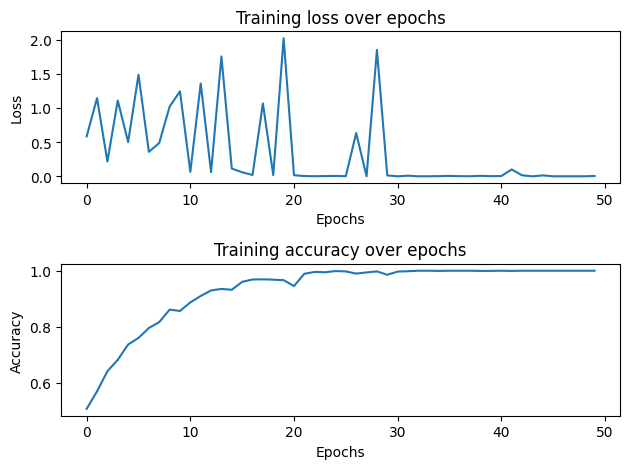

In [17]:
accuracy_list = []
loss_list = []




output_list = []
num_epochs = 50
for epoch in range(num_epochs):
    true_labels = []
    pred_labels = []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)  # Get the predicted classes

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Convert to numpy arrays for use with sklearn
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    accuracy_list.append(accuracy)
    loss_list.append(loss.item())

 
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

x_list = [x for x in range(num_epochs)]

plt.subplot(2, 1, 1)  # (rows, columns, subplot index)
plt.plot(x_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss over epochs')

# Create the second subplot
plt.subplot(2, 1, 2)  # (rows, columns, subplot index)
plt.plot(x_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy over epochs')


# Adjust the spacing between plots
plt.tight_layout()

# Display the plots
plt.show()


## Testing

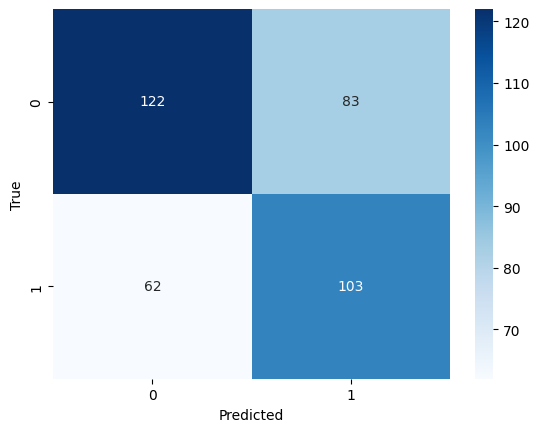

Accuracy: 0.6081081081081081
ROC AUC: 0.6096821877309682


In [25]:
model = model.to(device)
model.eval()  # Set the model to evaluation mode

true_labels = []
pred_labels = []
outputs_list = []

# Loop through the test data
for inputs, labels in test_data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[:, np.newaxis, :, :]
    inputs = inputs.float()


    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)  # Get the predicted classes

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    outputs_list.extend(outputs.detach().cpu().numpy())

# Convert to numpy arrays for use with sklearn
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute ROC AUC
roc_auc = roc_auc_score(label_binarize(true_labels, classes=[0,1]),
                        label_binarize(pred_labels, classes=[0,1]), 
                        average='macro')

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")